<a href="https://www.kaggle.com/code/aletbm/mobile-price-classification-with-sklearn-tf?scriptVersionId=142483947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📱 Mobile Price Classification with SKLearn & TF

<img src="https://images.ctfassets.net/wcfotm6rrl7u/QoPHqpmAs0eezhAtNNALl/9ccb0021a6a94ee2e1e2d421335e9452/nokia_C21_Plus-VIDEO-desktop.png">

In [1]:
!pip install mplcyberpunk
!pip install missingno

# 📚 Import packages

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import keras as K

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import mplcyberpunk
import missingno as msno

import random
plt.style.use("cyberpunk")

# 🗝️ Seed configuration for reproducibility of results

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# 📢 About Dataset
## Context
Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.

He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.

Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.

In this problem you do not have to predict actual price but a price range indicating how high the price is
## Features:
- **id**: ID
- **battery_power**: Total energy a battery can store in one time measured in mAh
- **blue**: Has bluetooth or not
- **clock_speed**: speed at which microprocessor executes instructions
- **dual_sim**: Has dual sim support or not
- **fc**: Front Camera mega pixels
- **four_g**: Has 4G or not
- **int_memory**: Internal Memory in Gigabytes
- **m_dep**: Mobile Depth in cm
- **mobile_wt**: Weight of mobile phone
- **n_cores**: Number of cores of processor
- **pc**: Primary Camera mega pixels
- **px_height**: Pixel Resolution Height
- **px_width**: Pixel Resolution Width
- **ram**: Random Access Memory in Megabytes
- **sc_h**: Screen Height of mobile in cm
- **sc_w**: Screen Width of mobile in cm
- **talk_time**: Longest time that a single battery charge will last when you are
- **three_g**: Has 3G or not
- **touch_screen**: Has touch screen or not
- **wifi**: Has wifi or not

# 🗃️ Loading data

In [5]:
train = pd.read_csv("../input/mobile-price-classification/train.csv")
test = pd.read_csv("../input/mobile-price-classification/test.csv")
test_id = test['id'].copy()
test.drop(['id'], axis=1, inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

## Let's take a look at the content of our data

In [7]:
pd.options.display.max_columns = None
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [8]:
test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [9]:
print(f'Amount of data in training dataset: {train.shape[0]}')
print(f'Amount of data in test dataset: {test.shape[0]}')

Amount of data in training dataset: 2000
Amount of data in test dataset: 1000


## Grouping of features and converting types

In [10]:
label = "price_range"
binary_col = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]
numeric_col = ["battery_power", "clock_speed", "fc", "int_memory", "m_dep", "mobile_wt", "n_cores", "pc", "px_height", "px_width", "ram", "sc_h", "sc_w", "talk_time"]

In [11]:
train[binary_col] = train[binary_col].astype("int8")

# 🕳️ Looking for NaN values and duplicate data

<AxesSubplot:>

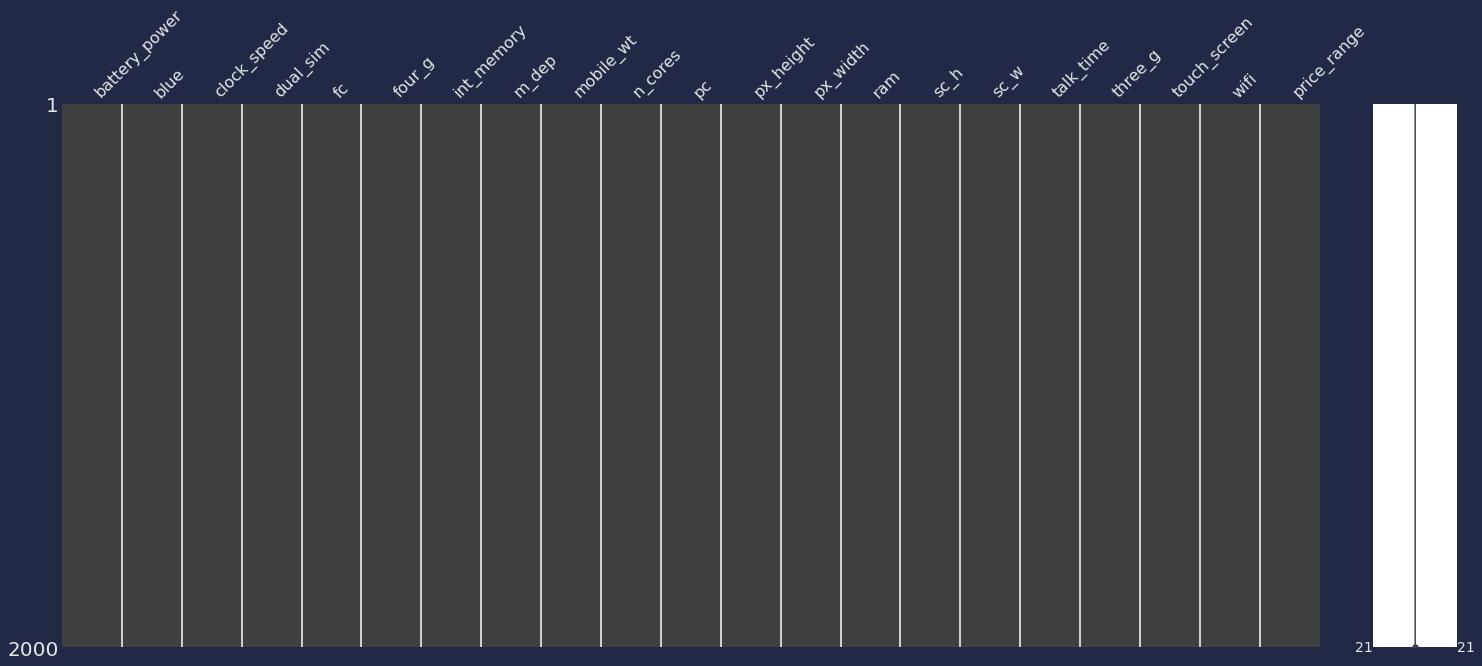

In [12]:
msno.matrix(train)

<AxesSubplot:>

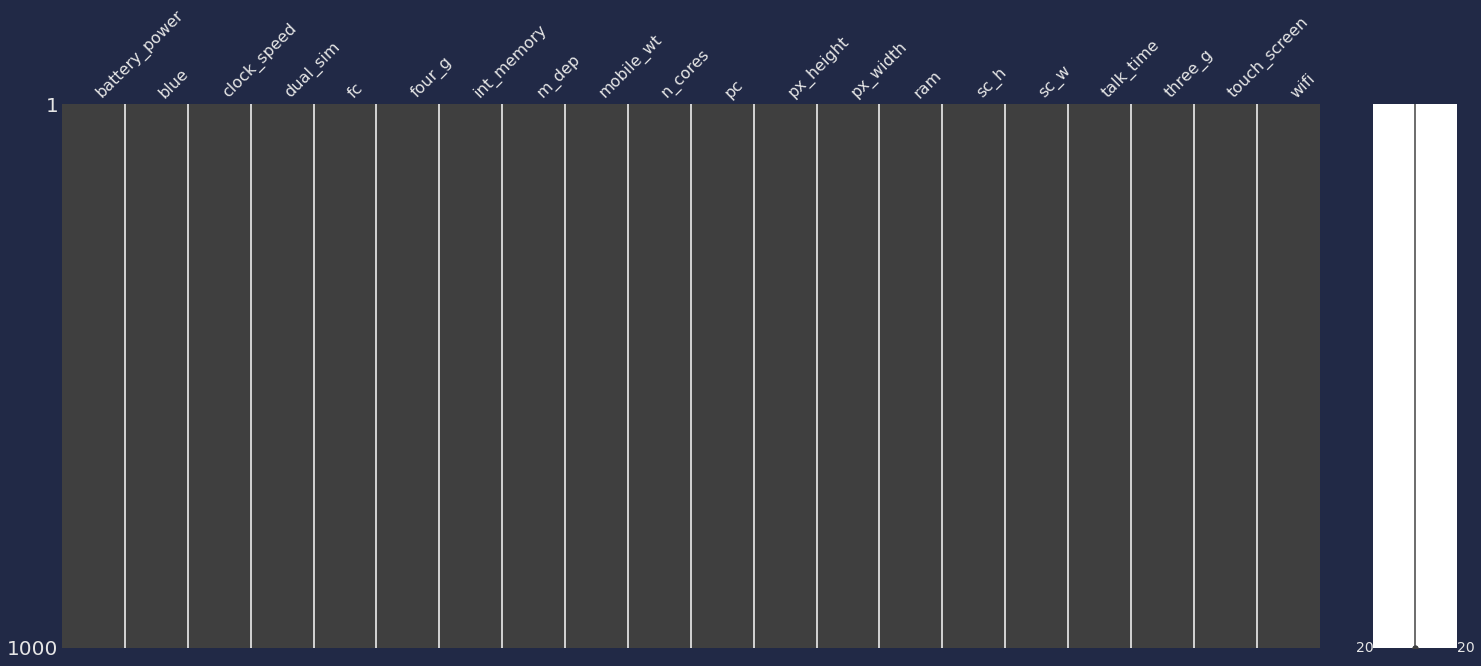

In [13]:
msno.matrix(test)

## Looking for duplicated rows

In [14]:
train.duplicated().sum()

0

In [15]:
test.duplicated().sum()

0

# 📊 Exploratory data analysis

In [16]:
def plot(dataset, hue, columns, box=False, figsize=(25, 10)):
    f=round(np.ceil(len(columns)/2))
    fig,axs = plt.subplots(f, 2, figsize=figsize)
    i=1
    for feature in columns:
        plt.subplot(f,2,i)
        if box == False:
            sns.histplot(data=dataset, x=feature, kde=True, hue=hue, palette=colors)
        else:
            sns.boxplot(data=dataset, x=feature, palette=colors)
        i+=1
    return

colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

## Is the data balanced?

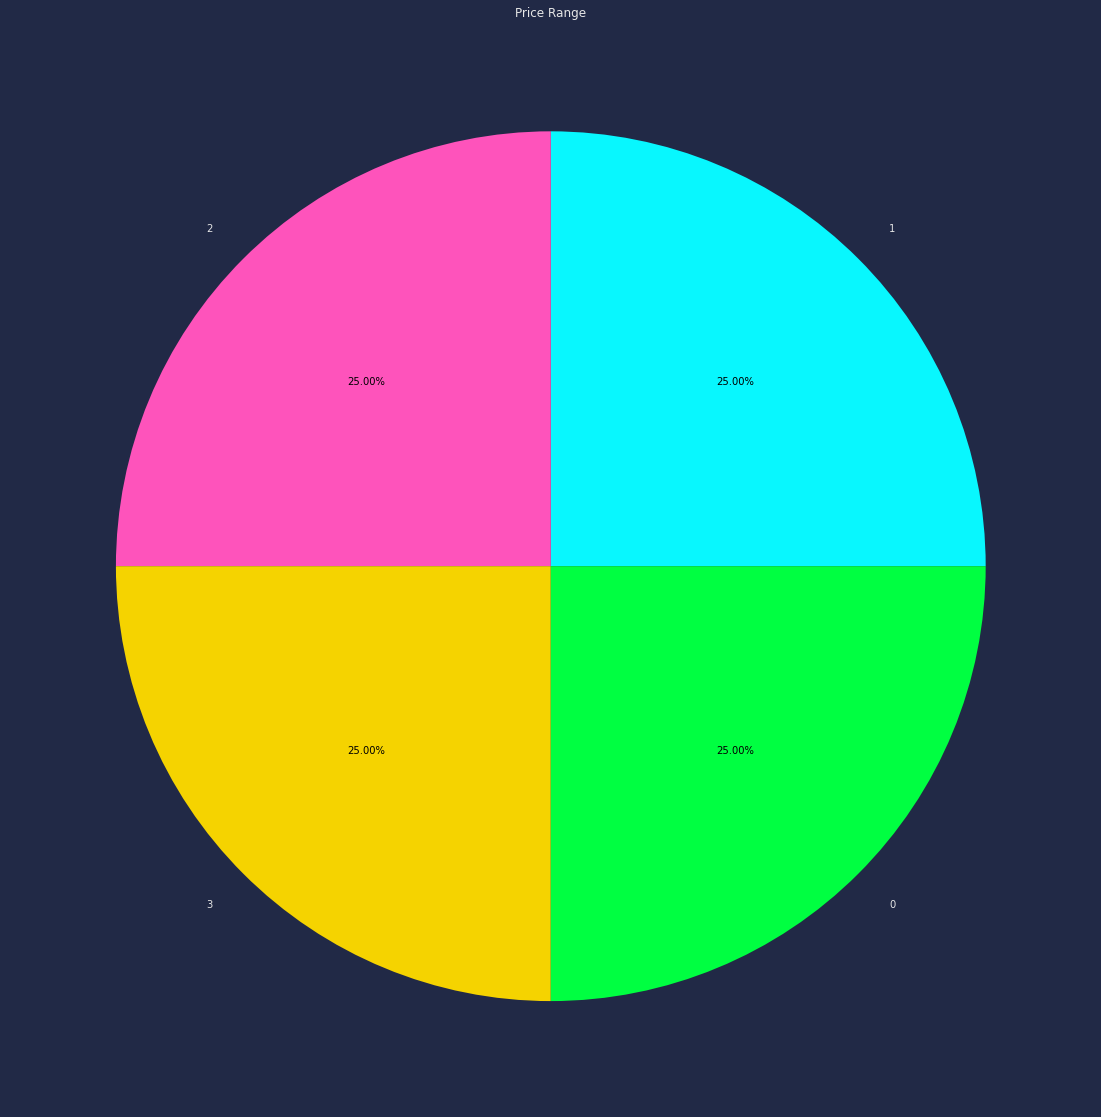

In [17]:
sizes = train["price_range"].value_counts()
plt.figure(figsize=(20, 20))
_, _, autotexts = plt.pie(sizes, labels=train["price_range"].unique(), autopct='%1.2f%%')
for autotext in autotexts:
    autotext.set_color('black')
plt.title("Price Range")
plt.show()

## Detecting outliers:

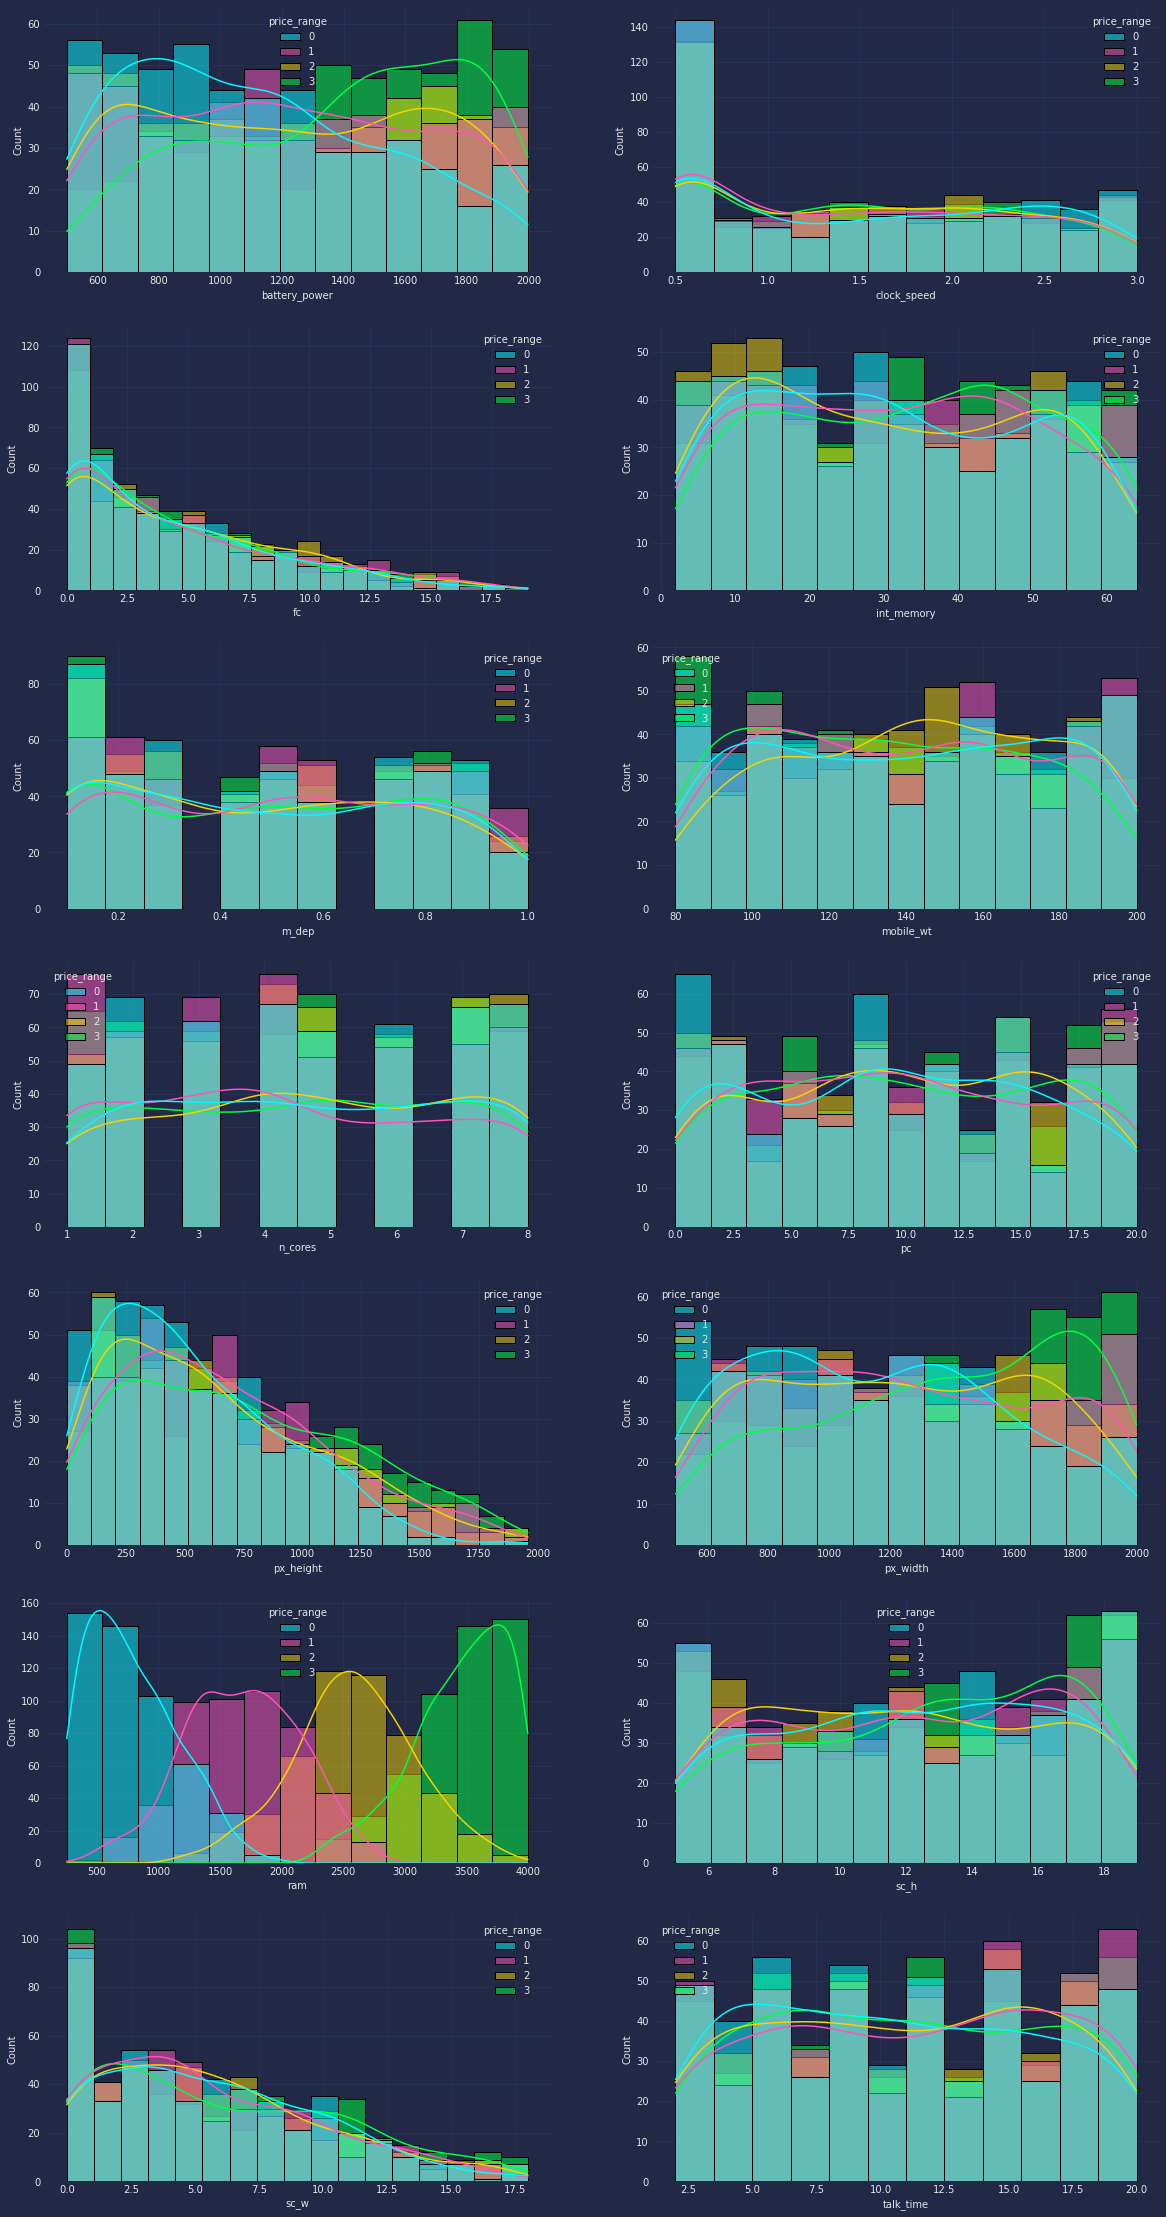

In [18]:
plot(train, label, numeric_col, figsize=(20, 40))

Some important observations:
* **battery_power**: The mobiles most expensive have a battery with more charge. This meaning that these mobiles last longer on. This feature seems to affect the price range.
* **fc**: We can see that there zeros values, this is possible in too old models, but this feature seem to not affect the price range. However, I would expect this type of mobile to be cheaper, this is very strange 🤔.
* **pc**: Same that fc, old models might not have primary camera but they should to be cheaper 🤨.
* **px_height**: 😐 This is very, very strange, **is there a expensive mobile without height resolution?** We can detect severals errors, <span style="color:red">**this is imposible since this meaning that these mobiles haven't screen.**</span>
* **px_width**: This feature seem to be more reasonable. The mobiles with more resolution width are most expensive, this meaning a screen more big and obviously this affect the price range.
* **ram**: The RAM memory affect the price range clearly. The more RAM memory, the higher the price, this seems reasonable.
* **sc_w**: Same that px_height. <span style="color:red">**Zero screen width meaning that mobile haven't screen.**</span>

In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [20]:
train[train["px_height"] == 0]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1481,1834,0,2.1,0,7,1,40,0.1,99,4,11,0,1987,3692,13,0,16,1,1,0,3
1933,897,1,2.0,0,3,1,2,0.6,154,8,10,0,994,1958,7,5,7,1,1,0,1


In [21]:
train[train["sc_w"] == 0]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
12,1815,0,2.8,0,2,0,33,0.6,159,4,17,607,748,1482,18,0,2,1,0,0,1
24,503,0,1.2,1,5,1,8,0.4,111,3,13,201,1245,2583,11,0,12,1,0,0,1
33,1310,1,2.2,1,0,1,51,0.6,100,4,0,178,1919,3845,7,0,12,1,1,0,3
42,1253,1,0.5,1,5,1,5,0.2,152,2,19,685,714,1878,15,0,4,1,1,0,1
50,1547,1,3.0,1,2,1,14,0.7,198,3,19,1042,1832,2059,5,0,15,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,772,0,1.0,1,0,1,23,0.6,97,7,11,317,1805,2782,7,0,17,1,0,0,2
1920,591,1,0.5,1,1,1,16,0.9,90,6,17,892,1603,3746,5,0,5,1,1,0,3
1946,590,1,1.2,1,0,0,32,0.4,141,6,1,227,509,1817,10,0,6,0,1,0,0
1954,686,1,2.7,1,0,0,36,0.1,194,4,1,64,745,1503,10,0,13,0,0,0,0


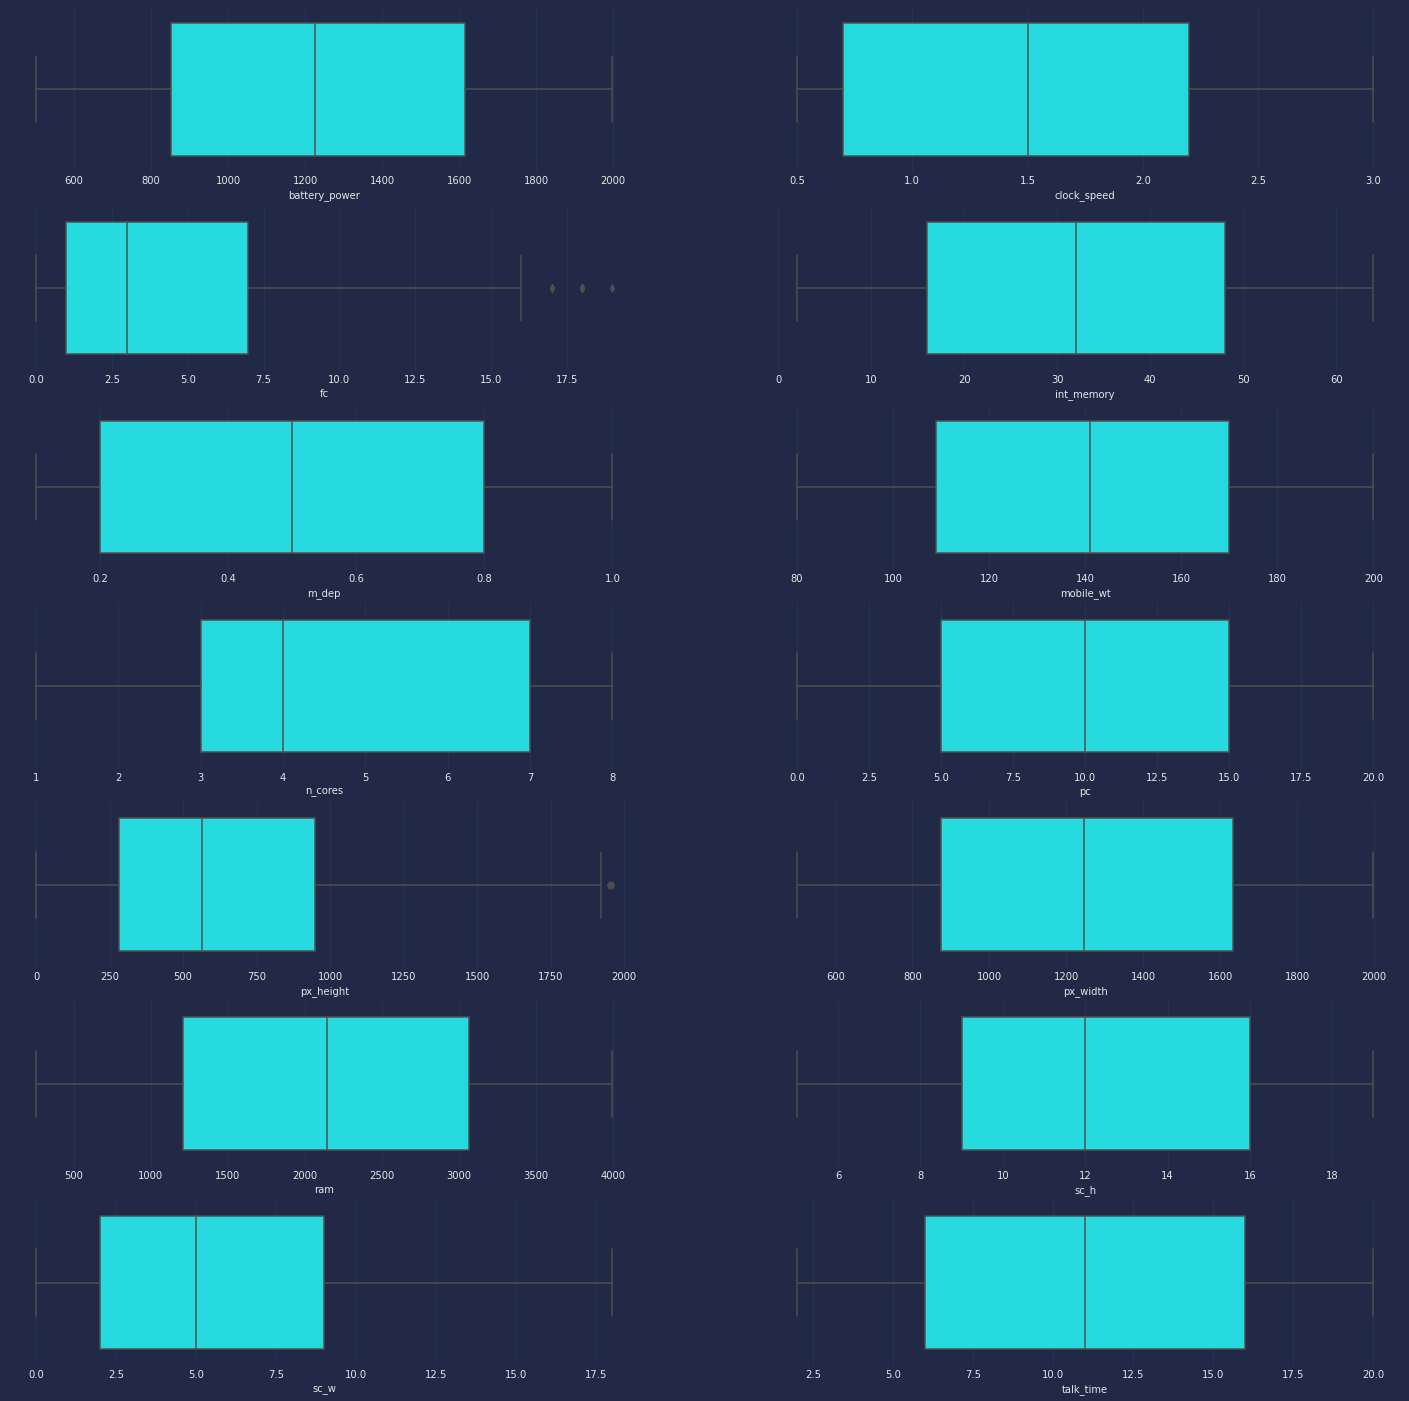

In [22]:
plot(train, None, numeric_col, box=True, figsize=(25, 25))

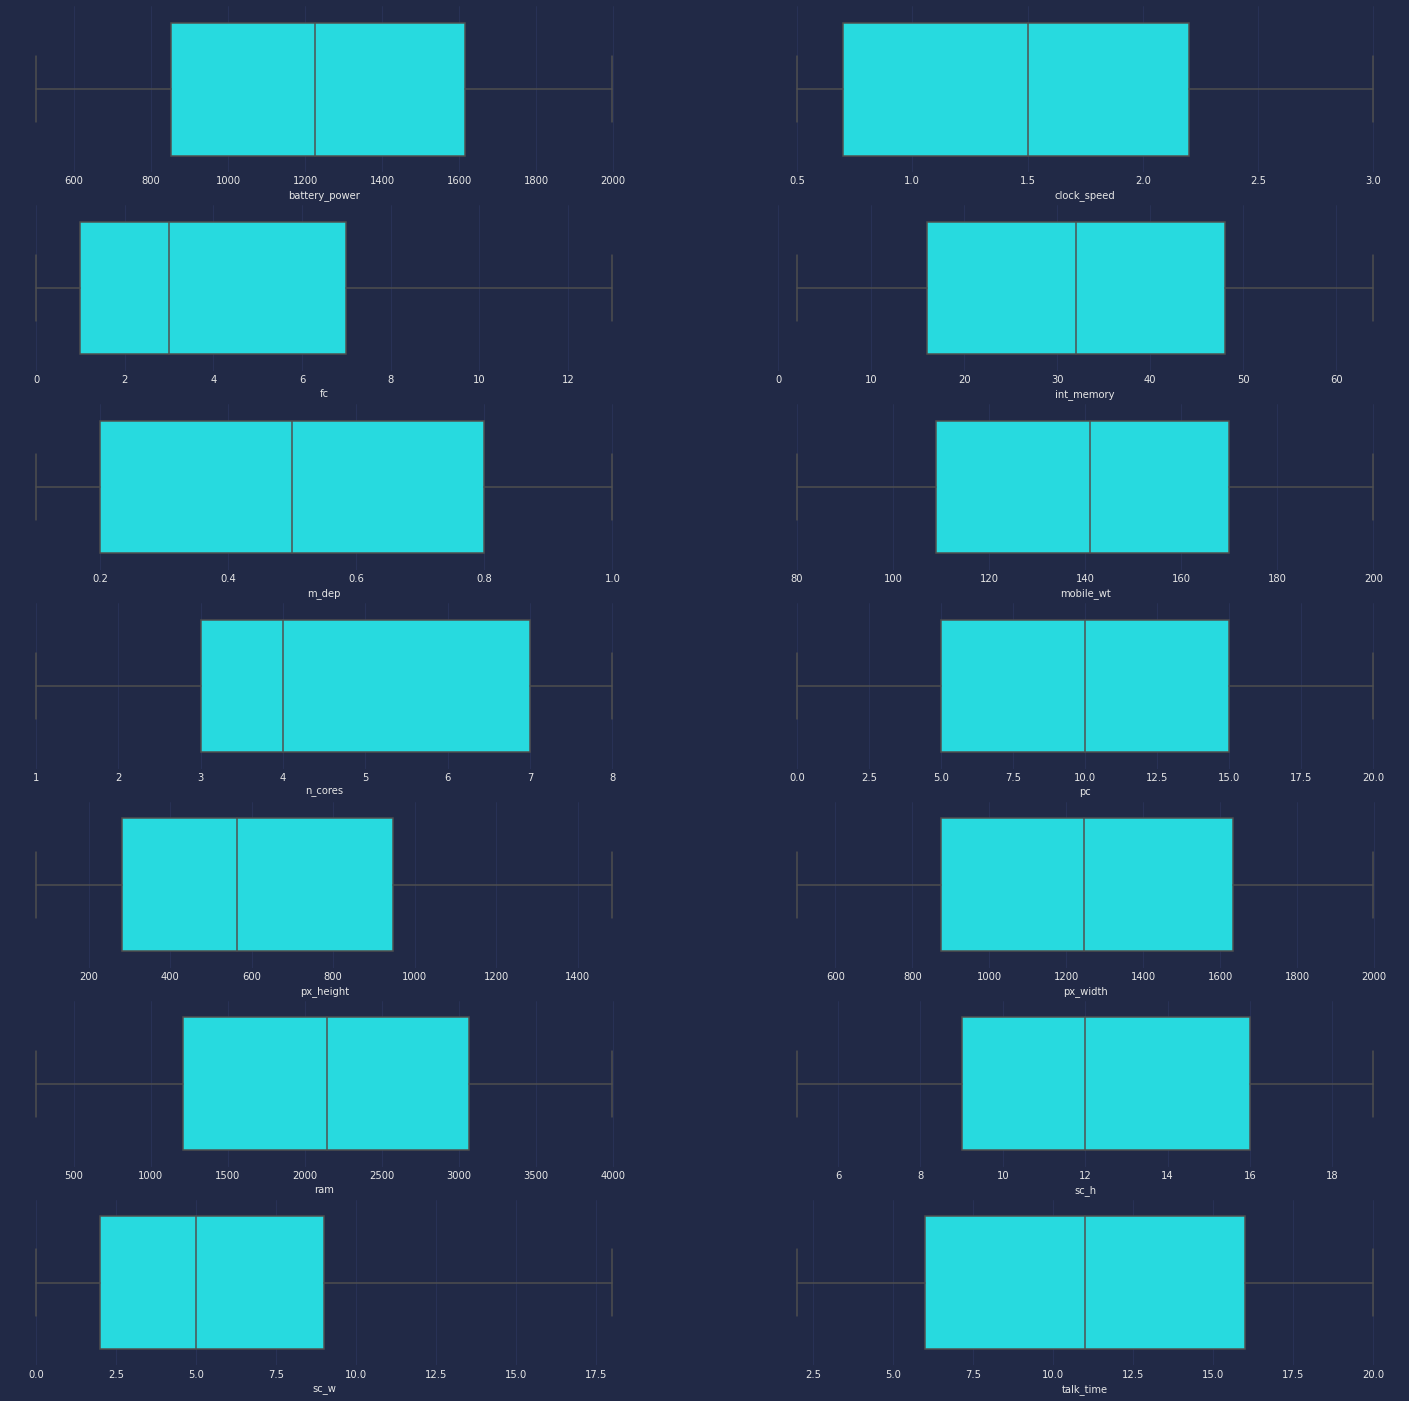

In [23]:
from scipy.stats.mstats import winsorize

def detect_outliers(df, columns, method="IQR", llimit=0.05, ulimit=0.05):
    df_ = df.copy()
    for col in columns:
        if method == "IQR":
            Q1 = df_[col].quantile(0.25)
            Q3 = df_[col].quantile(0.75)
            IQR = Q3 - Q1
            interval = ((df_[col] < Q1 - 1.5*IQR) | (df_[col] > Q3 + 1.5*IQR))
            df_.loc[interval, col] = df_.loc[~interval, col].mean()
        if method == "WIN":
            df_[col] = winsorize(df_[col], limits = [llimit,ulimit])
    return df_

train = detect_outliers(train, ["fc", "px_height"], "WIN")

plot(train, None, numeric_col, box=True, figsize=(25, 25))

In [24]:
train.loc[train["px_height"] == 0, "px_height"] = train[train["px_height"] != 0]["px_height"].mean()
train.loc[train["sc_w"] == 0, "sc_w"] = train[train["sc_w"] != 0]["sc_w"].mean()
train.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.518500,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.495000,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.522250,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.509500,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.198000,4.065595,0.0,1.00,3.0,7.00,13.0
four_g,2000.0,0.521500,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.046500,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.501750,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.249000,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.520500,2.287837,1.0,3.00,4.0,7.00,8.0


# 🔧 Feature engineering

In [25]:
train["sc_area"] = train["sc_w"] * train["sc_h"]
train["px_area"] = train["px_width"] * train["px_height"]
train["total_clock_speed"] = train["n_cores"] * train["clock_speed"]
train["mAh_per_unitTime"] = train["battery_power"] / train["talk_time"]
train["PPI_screen"] =  (train["px_width"]**2 + train["px_height"]**2)**(1/2) / (train["sc_w"]**2 + train["sc_h"]**2)**(1/2)
train["resolution_screen"] = "SD"
train.loc[(train["px_width"] >= 1280)&(train["px_height"] >= 720), "resolution_screen"] = "HD"
train.loc[(train["px_width"] >= 1920)&(train["px_height"] >= 1080), "resolution_screen"] = "FHD"
train.loc[(train["px_width"] >= 2560)&(train["px_height"] >= 1440), "resolution_screen"] = "QHD"
train.loc[(train["px_width"] >= 3840)&(train["px_height"] >= 2160), "resolution_screen"] = "4K"

test["sc_area"] = test["sc_w"] * test["sc_h"]
test["px_area"] = test["px_width"] * test["px_height"]
test["total_clock_speed"] = test["n_cores"] * test["clock_speed"]
test["mAh_per_unitTime"] = test["battery_power"] / test["talk_time"]
test["PPI_screen"] = ((test["px_width"]**2 + test["px_height"]**2)**(1/2)) / ((test["sc_w"]**2 + test["sc_h"]**2)**(1/2))
test["resolution_screen"] = "SD"
test.loc[(test["px_width"] >= 1280)&(test["px_height"] >= 720), "resolution_screen"] = "HD"
test.loc[(test["px_width"] >= 1920)&(test["px_height"] >= 1080), "resolution_screen"] = "FHD"
test.loc[(test["px_width"] >= 2560)&(test["px_height"] >= 1440), "resolution_screen"] = "QHD"
test.loc[(test["px_width"] >= 3840)&(test["px_height"] >= 2160), "resolution_screen"] = "4K"

## Regrouping of features

In [26]:
numeric_col += ["sc_area", "px_area", "total_clock_speed", "mAh_per_unitTime", "PPI_screen"]
categorical_col = ["resolution_screen"]

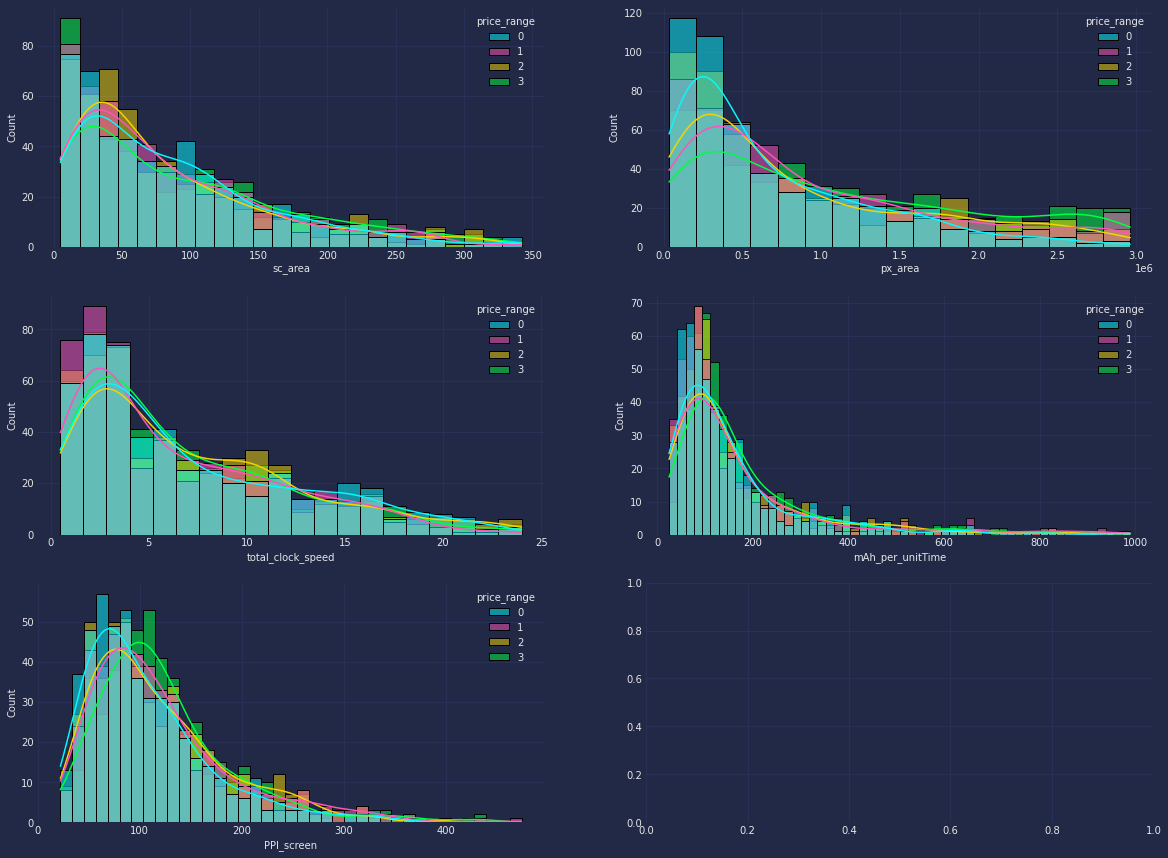

In [27]:
plot(train, label, ["sc_area", "px_area", "total_clock_speed", "mAh_per_unitTime", "PPI_screen"], figsize=(20, 15))

## Bivariate visualizations

In [28]:
fig= plt.figure(figsize=(25, 10))
px.scatter(train, x="ram", y="battery_power", color=label, color_continuous_scale=[(0, colors[0]), (1, colors[1])], template="plotly_dark")

<Figure size 1800x720 with 0 Axes>

In [29]:
fig= plt.figure(figsize=(25, 10))
px.scatter(train, x="ram", y="px_width", color=label, color_continuous_scale=[(0, colors[0]), (1, colors[1])], template="plotly_dark")

<Figure size 1800x720 with 0 Axes>

## Multivariate visualizations:

In [30]:
fig = px.scatter_3d(train, x='ram', y='battery_power', z='px_width', color='price_range', color_continuous_scale=[(0, colors[0]), (1, colors[1])], template="plotly_dark")
fig.show()

In [31]:
fig = px.scatter_3d(train, x='PPI_screen', y='px_height', z='px_width', color='price_range', color_continuous_scale=[(0, colors[0]), (1, colors[1])], template="plotly_dark")
fig.show()

# 🔢 Feature encoding

In [32]:
train["resolution_screen"].value_counts()

SD     1438
HD      501
FHD      61
Name: resolution_screen, dtype: int64

In [33]:
train = pd.get_dummies(train, columns=["resolution_screen"])
test = pd.get_dummies(test, columns=["resolution_screen"])
train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,sc_area,px_area,total_clock_speed,mAh_per_unitTime,PPI_screen,resolution_screen_FHD,resolution_screen_HD,resolution_screen_SD
0,842,0,2.2,0,1,0,7,0.6,188,2,2,71.0,756,2549,9,7.0,19,0,0,1,1,63.0,53676.0,4.4,44.315789,66.597355,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905.0,1988,2631,17,3.0,7,1,1,0,2,51.0,1799140.0,1.5,145.857143,126.533135,0,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263.0,1716,2603,11,2.0,9,1,1,0,2,22.0,2167308.0,2.5,62.555556,190.574395,0,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216.0,1786,2769,16,8.0,11,1,0,0,2,128.0,2171776.0,15.0,55.909091,120.784571,0,1,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208.0,1212,1411,8,2.0,15,1,1,0,1,16.0,1464096.0,2.4,121.400000,207.513571,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222.0,1890,668,13,4.0,19,1,1,0,0,52.0,2309580.0,3.0,41.789474,165.470402,0,1,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915.0,1965,2032,11,10.0,16,1,1,1,2,110.0,1797975.0,10.4,122.812500,145.807938,0,1,0
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868.0,1632,3057,9,1.0,5,1,1,0,3,9.0,1416576.0,7.2,382.200000,204.129562,0,1,0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336.0,670,869,18,10.0,19,1,1,1,0,180.0,225120.0,4.5,79.578947,36.400420,0,0,1


# 🧮 Correlations of our data

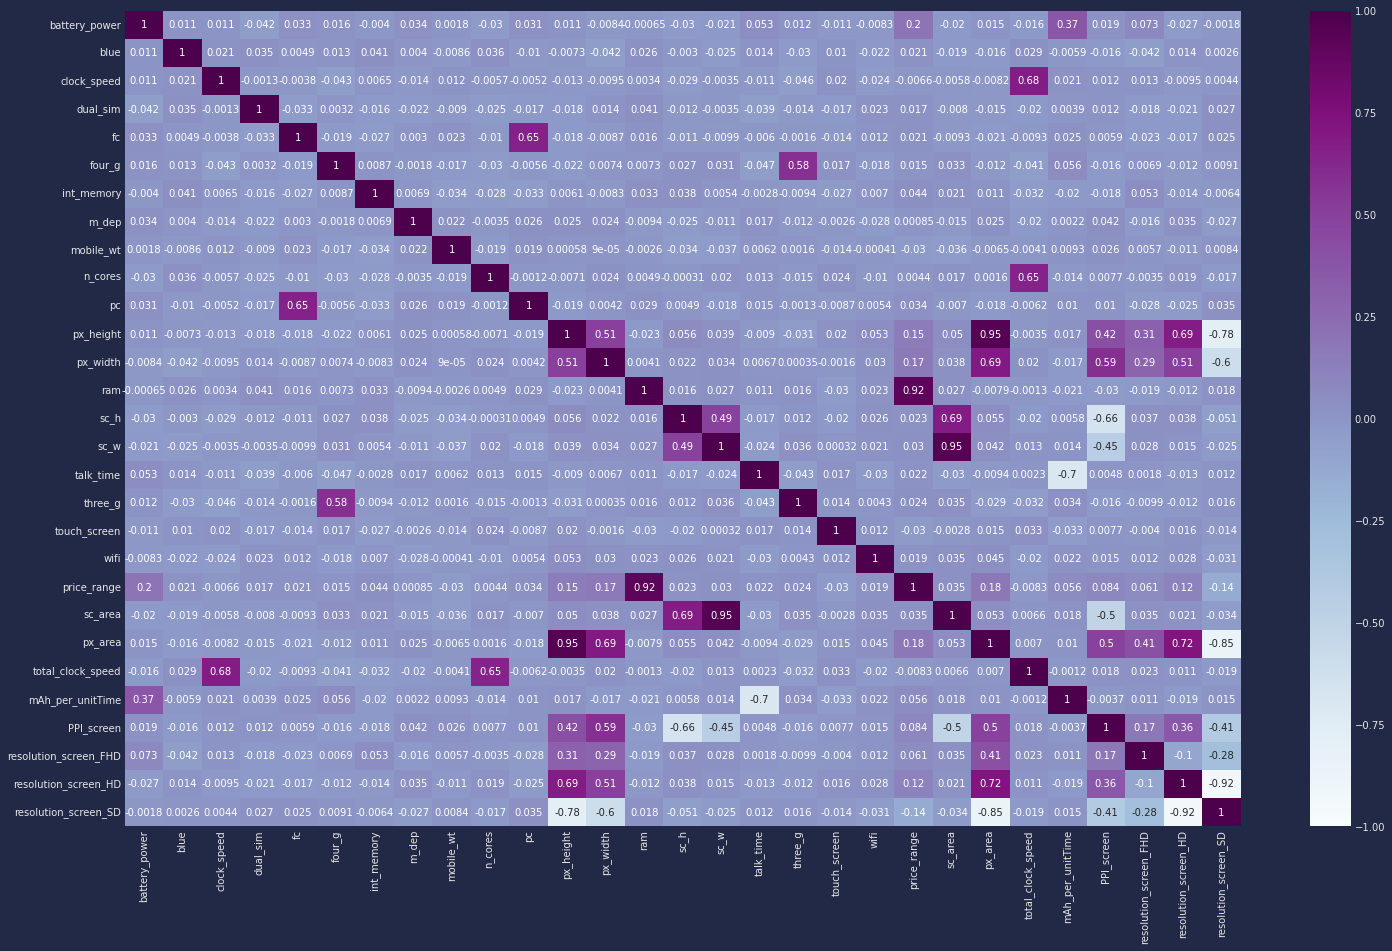

In [34]:
plt.figure(figsize=(25,15))
sns.heatmap(train.corr(), annot=True,cmap="BuPu", vmin=-1, vmax=1);

## Checking multicollinearity problem

In [35]:
def detect_VIF(df):
    df_ = df.copy()
    df_.drop(["price_range"], axis=1, inplace=True)
    df_['intercept'] = 1
    with np.errstate(divide='ignore'):
        while(True):
            df_vif = pd.DataFrame(columns=["Features", "VIF"])
            df_vif["Features"] = df_.columns
            df_vif["VIF"] = [variance_inflation_factor(df_.values, i) for i in range(len(df_.columns))]
            df_vif = df_vif[df_vif["Features"] != "intercept"].sort_values("VIF", ascending=False)
            if df_vif.iloc[0]["VIF"] > 5:
                df_.drop([df_vif.iloc[0]["Features"]], axis=1, inplace=True)
            else:
                next_ = False
                break
    df_.drop(["intercept"], axis=1, inplace=True)
    return df[df_.columns.tolist() + ["price_range"]], df_vif
        
train_clean, df_vif = detect_VIF(train)
df_vif

,Features,VIF
20,mAh_per_unitTime,2.902313
22,resolution_screen_HD,2.829398
11,px_height,2.677250
16,talk_time,2.507742
10,pc,1.740735
4,fc,1.736616
12,px_width,1.617680
21,resolution_screen_FHD,1.600085
5,four_g,1.531008
17,three_g,1.528870


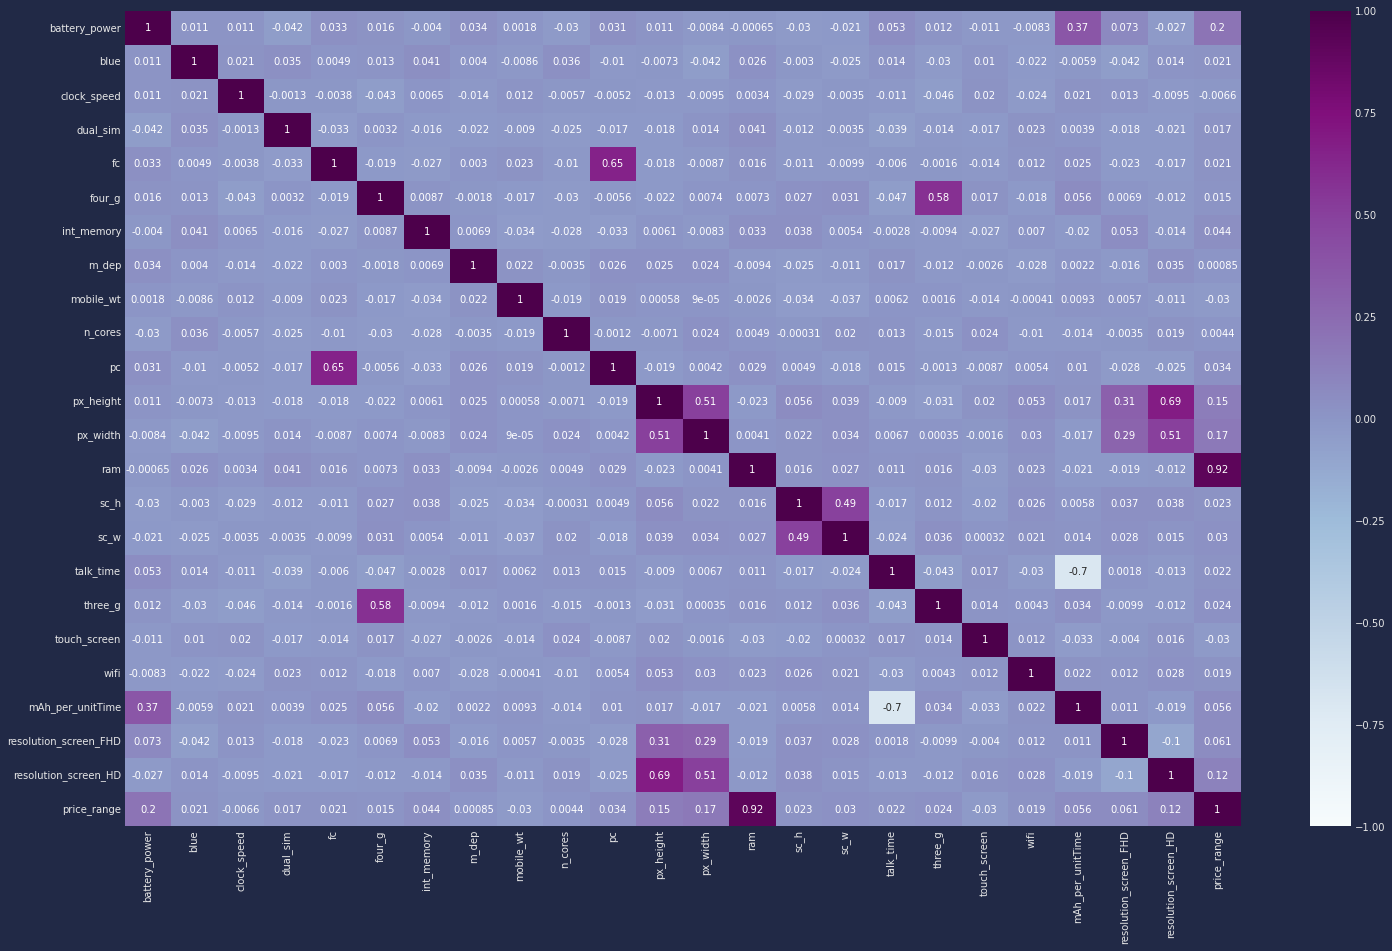

In [36]:
plt.figure(figsize=(25,15))
sns.heatmap(train_clean.corr(), annot=True,cmap="BuPu", vmin=-1, vmax=1);

# ✂️ Splitting to dataset

In [37]:
X = train_clean.drop("price_range", axis=1)
y = train_clean["price_range"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=seed_value, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.30, random_state=seed_value, stratify=y_valid)
test_ = test.copy()
print(f'Cantidad de datos en dataset de entrenamiento: {X_train.shape[0]}')
print(f'Cantidad de datos en dataset de validacion: {X_valid.shape[0]}')
print(f'Cantidad de datos en dataset de prueba: {X_test.shape[0]}')

Cantidad de datos en dataset de entrenamiento: 1400
Cantidad de datos en dataset de validacion: 420
Cantidad de datos en dataset de prueba: 180


# 📐 Standardization and Normalization

In [38]:
numeric_col = X_train.select_dtypes(["int64", "float64"]).columns.tolist()
std = StandardScaler()
mms = MinMaxScaler()

X_train[numeric_col] = std.fit_transform(X_train[numeric_col], y=y_train)
X_train[numeric_col] = mms.fit_transform(X_train[numeric_col], y=y_train)

X_valid[numeric_col] = std.transform(X_valid[numeric_col])
X_valid[numeric_col] = mms.transform(X_valid[numeric_col])

X_test[numeric_col] = std.transform(X_test[numeric_col])
X_test[numeric_col] = mms.transform(X_test[numeric_col])

test_[numeric_col] = std.transform(test_[numeric_col])
test_[numeric_col] = mms.transform(test_[numeric_col])

In [39]:
X_train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,mAh_per_unitTime,resolution_screen_FHD,resolution_screen_HD
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,0.491328,0.499286,0.410429,0.505714,0.316429,0.515714,0.486244,0.450159,0.501048,0.509184,0.491107,0.405488,0.497307,0.498896,0.521020,0.314615,0.498452,0.756429,0.503571,0.512143,0.151733,0.029286,0.247857
std,0.294489,0.500178,0.329720,0.500146,0.307272,0.499932,0.293703,0.322341,0.294677,0.325707,0.302446,0.299522,0.285827,0.290528,0.297156,0.234505,0.308123,0.429390,0.500166,0.500031,0.172634,0.168666,0.431923
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227273,0.000000,0.080000,0.000000,0.076923,0.000000,0.225806,0.111111,0.241667,0.285714,0.237500,0.150460,0.249666,0.253808,0.285714,0.117647,0.222222,1.000000,0.000000,0.000000,0.051728,0.000000,0.000000
50%,0.481618,0.000000,0.400000,1.000000,0.230769,1.000000,0.467742,0.444444,0.508333,0.571429,0.500000,0.357143,0.498665,0.500000,0.500000,0.294118,0.500000,1.000000,1.000000,1.000000,0.089151,0.000000,0.000000
75%,0.743984,1.000000,0.720000,1.000000,0.538462,1.000000,0.741935,0.777778,0.750000,0.857143,0.750000,0.627652,0.742991,0.746526,0.785714,0.470588,0.777778,1.000000,1.000000,1.000000,0.173873,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# ✔️❌️ Feature Selection

In [40]:
sfs_forward = SequentialFeatureSelector(estimator=LogisticRegression(),
                                        direction="forward",
                                        scoring='f1_macro',
                                        cv=5)

sfs_forward.fit(X_train, y_train)

selected_features = sfs_forward.get_feature_names_out()
selected_features

array(['battery_power', 'blue', 'clock_speed', 'fc', 'mobile_wt',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
       'resolution_screen_HD'], dtype=object)

In [41]:
X_train = X_train[selected_features].copy()
X_valid = X_valid[selected_features].copy()
X_test = X_test[selected_features].copy()
test_ = test_[selected_features].copy()

# 🤖 Building and training models

## Classifiers implemented with ScitKit-Learn

### Logistic Regression Classifier and Grid Search for model tuning

In [42]:
lr = LogisticRegression(random_state=seed_value)

param_grid = {"max_iter": [200, 250, 300],
             "C": np.linspace(40, 43, 11),
             "tol":np.linspace(1e-2, 1e-1, 11)}

grid = GridSearchCV(lr, param_grid, cv=5)
grid.fit(X_valid, y_valid)
grid.best_params_

{'C': 42.4, 'max_iter': 200, 'tol': 0.028000000000000004}

In [43]:
lr_best = grid.best_estimator_
lr_best.fit(X_train, y_train)

LogisticRegression(C=42.4, max_iter=200, random_state=42,
                   tol=0.028000000000000004)

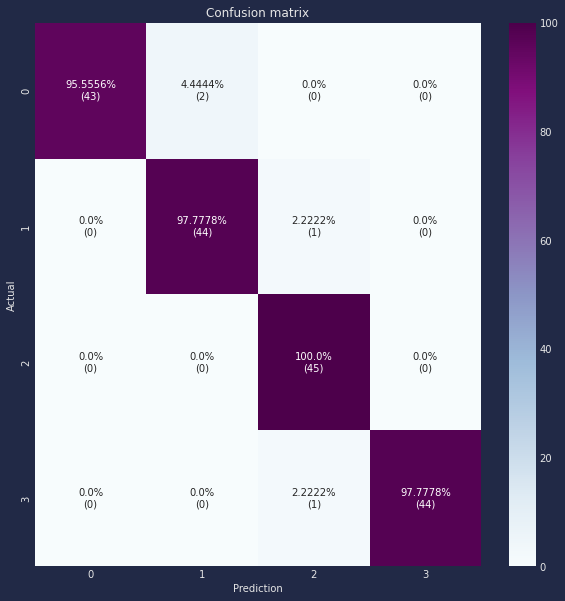

In [44]:
def y_cm(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    cm_val = confusion_matrix(y_test, y_pred)
    cm_pgs = np.round(confusion_matrix(y_test, y_pred, normalize='true')*100, 4)

    formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(4, 4)

    sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
    plt.title("Confusion matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    return

y_pred_lr = lr_best.predict(X_test)
y_cm(y_test, y_pred_lr)

In [45]:
pd.DataFrame(data=classification_report(y_test, y_pred_lr, digits=6, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,1.000000,0.955556,0.977273,45.000000
1,0.956522,0.977778,0.967033,45.000000
2,0.957447,1.000000,0.978261,45.000000
3,1.000000,0.977778,0.988764,45.000000
accuracy,0.977778,0.977778,0.977778,0.977778
macro avg,0.978492,0.977778,0.977833,180.000000
weighted avg,0.978492,0.977778,0.977833,180.000000


### Random Forest Classifier and Grid Search for model tuning

In [46]:
rf = RandomForestClassifier(random_state=seed_value, bootstrap = True)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 11)]
max_depth = [int(x) for x in np.linspace(1, 30, num = 11)]
max_depth.append(None)

param_grid = {"n_estimators": n_estimators,
             "max_depth": max_depth}

grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid.fit(X_valid, y_valid)
grid.best_params_

{'max_depth': 15, 'n_estimators': 730}

In [47]:
rf_best = grid.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=730, random_state=42)

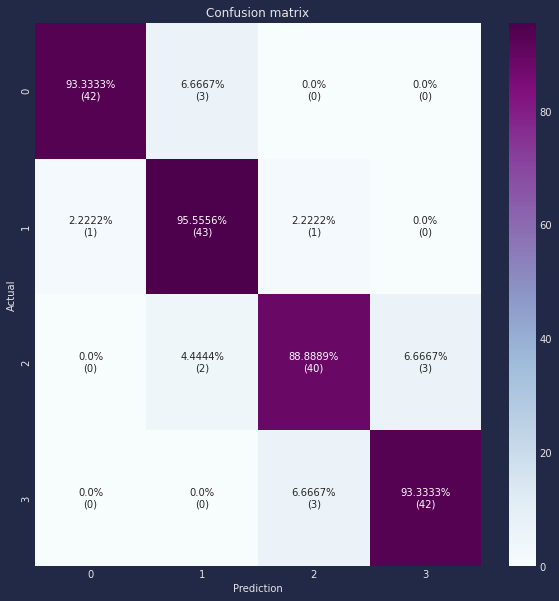

In [48]:
y_pred_rf = rf_best.predict(X_test)
y_cm(y_test, y_pred_rf)

In [49]:
pd.DataFrame(data=classification_report(y_test, y_pred_rf, digits=6, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.976744,0.933333,0.954545,45.000000
1,0.895833,0.955556,0.924731,45.000000
2,0.909091,0.888889,0.898876,45.000000
3,0.933333,0.933333,0.933333,45.000000
accuracy,0.927778,0.927778,0.927778,0.927778
macro avg,0.928750,0.927778,0.927872,180.000000
weighted avg,0.928750,0.927778,0.927872,180.000000


##  Classifiers implemented with Tensorflow

### Learning rate tuning

In [50]:
neurons = 512
reg= 0.0001

model = Sequential([
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg), input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(neurons//2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.4),
    Dense(neurons//4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.3),
    Dense(neurons//8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.2),
    Dense(neurons//16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.1),
    Dense(neurons//32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dense(4, activation='softmax')
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer='adam',
            metrics=['accuracy'])

model.summary()

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [51]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    callbacks=[lr_scheduler]
                    )

Epoch 1/100
44/44 [==============================] - 2s 15ms/step - loss: 1.4529 - accuracy: 0.2607 - val_loss: 1.4493 - val_accuracy: 0.3214
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 1.4514 - accuracy: 0.2707 - val_loss: 1.4462 - val_accuracy: 0.3095
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 1.4490 - accuracy: 0.2543 - val_loss: 1.4426 - val_accuracy: 0.2738
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 1.4475 - accuracy: 0.2336 - val_loss: 1.4380 - val_accuracy: 0.2738
Epoch 5/100
44/44 [==============================] - 0s 6ms/step - loss: 1.4358 - accuracy: 0.2907 - val_loss: 1.4184 - val_accuracy: 0.2881
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 1.4141 - accuracy: 0.3229 - val_loss: 1.3649 - val_accuracy: 0.5095
Epoch 7/100
44/44 [==============================] - 0s 6ms/step - loss: 1.3371 - accuracy: 0.4379 - val_loss: 1.2083 - val_accuracy: 0.5310
Epoch 8/100


Text(0, 0.5, 'Loss')

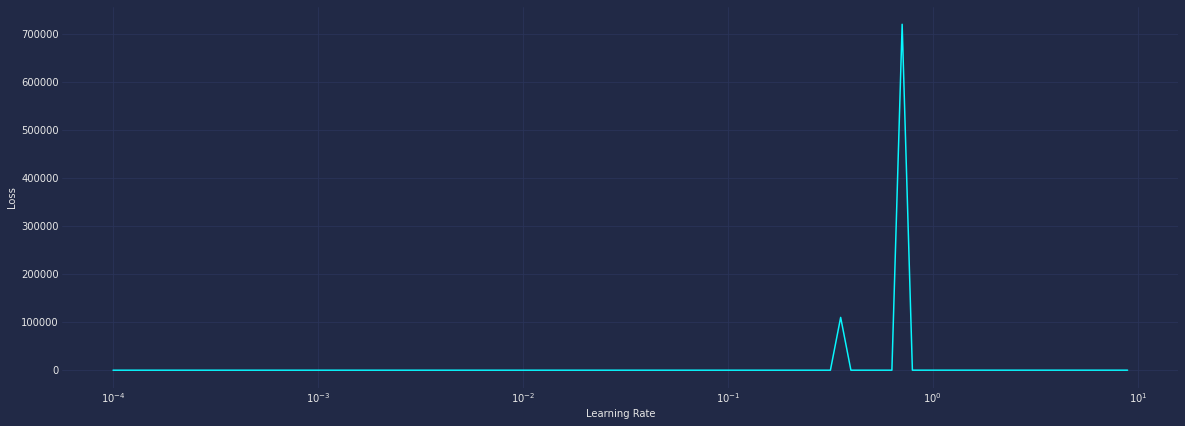

In [52]:
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(20,7))
plt.semilogx(lrs, history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [53]:
minimum = min(history.history['loss'])
index = history.history['loss'].index(minimum)
lr = lrs[index]
lr

0.003981071705534973

### Training with learning rate tuning

In [54]:
epochs = 300
model = Sequential([
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg), input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(neurons//2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.4),
    Dense(neurons//4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.3),
    Dense(neurons//8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.2),
    Dense(neurons//16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.1),
    Dense(neurons//32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dense(4, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               6144      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [55]:
callback = EarlyStopping(monitor='val_loss', patience=20, mode='min')
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    batch_size=64,
                    callbacks=[callback])

Epoch 1/300
22/22 [==============================] - 1s 20ms/step - loss: 1.3725 - accuracy: 0.3436 - val_loss: 1.0719 - val_accuracy: 0.5071
Epoch 2/300
22/22 [==============================] - 0s 8ms/step - loss: 1.0010 - accuracy: 0.5579 - val_loss: 0.7841 - val_accuracy: 0.5905
Epoch 3/300
22/22 [==============================] - 0s 8ms/step - loss: 0.8211 - accuracy: 0.6371 - val_loss: 0.5457 - val_accuracy: 0.8571
Epoch 4/300
22/22 [==============================] - 0s 9ms/step - loss: 0.6879 - accuracy: 0.7200 - val_loss: 0.4418 - val_accuracy: 0.8357
Epoch 5/300
22/22 [==============================] - 0s 8ms/step - loss: 0.6098 - accuracy: 0.7471 - val_loss: 0.4281 - val_accuracy: 0.8571
Epoch 6/300
22/22 [==============================] - 0s 8ms/step - loss: 0.4965 - accuracy: 0.8214 - val_loss: 0.3377 - val_accuracy: 0.8762
Epoch 7/300
22/22 [==============================] - 0s 8ms/step - loss: 0.5209 - accuracy: 0.7950 - val_loss: 0.4133 - val_accuracy: 0.8381
Epoch 8/300


### Accuracy and loss in training and validation set

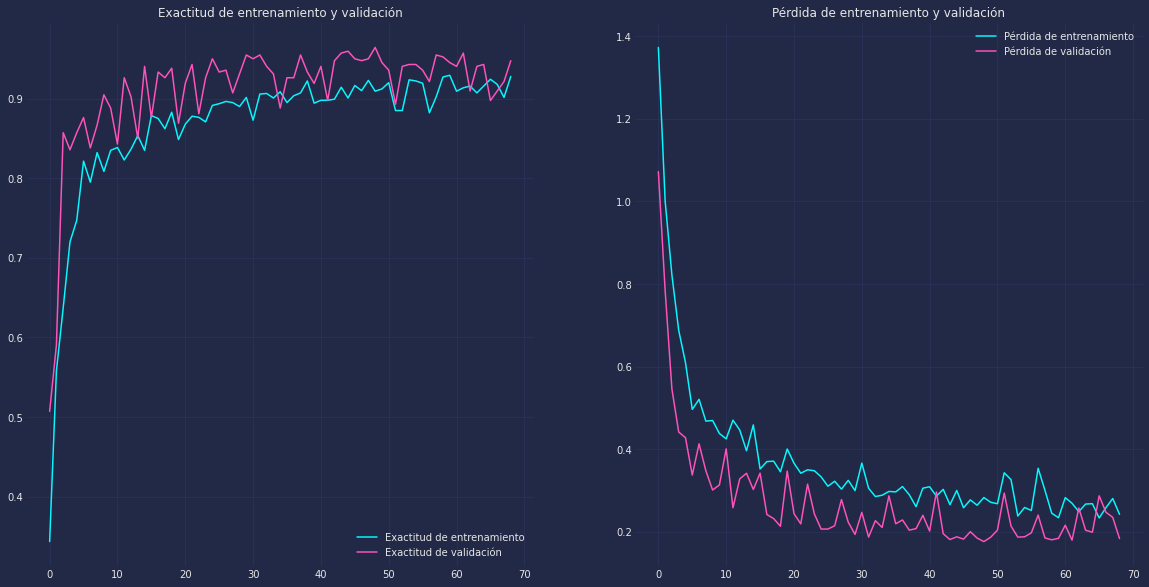

In [56]:
def plot_model_history(model_history, epochs):

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud de entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud de validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud de entrenamiento y validación')

    plt.subplot(122)
    plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida de entrenamiento y validación')

    plt.show()
    
plot_model_history(history, len(history.history['accuracy']))

### Save model

In [57]:
model.save("tfModel.h5")
model.save_weights('tf_Model_weight')

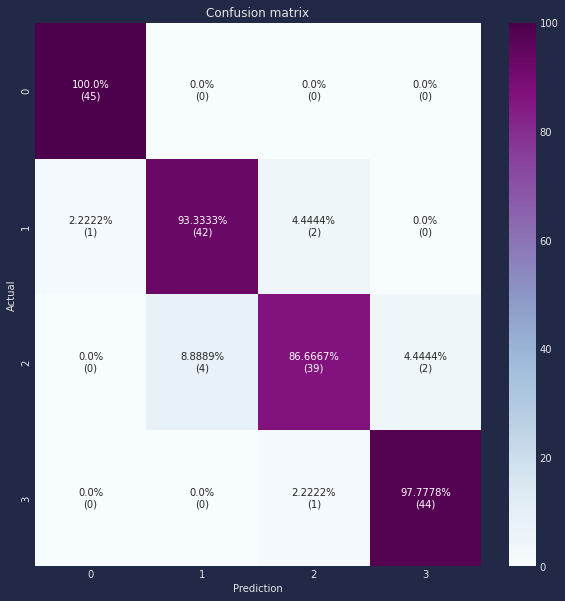

In [58]:
y_pred_tf = np.argmax(model.predict(X_test), axis=1)
y_cm(y_test, y_pred_tf)

# 🤔 Model comparision

In [59]:
def print_scores(y, y_pred, pp_scores=False):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred, average='macro')*100, recall_score(y, y_pred, average='macro')*100, f1_score(y, y_pred, average='weighted')*100
    if pp_scores == True:
        print(f"Accuracy:{ac}")
        print(f"Precision:{pr}")
        print(f"Recall:{rc}")
        print(f"F1-score:{f1}")
    return {'Accuracy': ac, 'Precision':pr, 'Recall':rc, 'F1-score':f1}

lr_scores = print_scores(y_test, y_pred_lr)
rf_scores = print_scores(y_test, y_pred_rf)
tf_scores = print_scores(y_test, y_pred_tf)

scores = pd.DataFrame(data=[list(lr_scores.values()),
                            list(rf_scores.values()),
                            list(tf_scores.values()),
                           ], columns=list(lr_scores.keys()))

scores = scores.transpose()
scores = scores.rename(columns={0:"Linear Regression",
                                1:"Random Forest",
                                2:"Neural Network"
                               })
scores.style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

,Linear Regression,Random Forest,Neural Network
Accuracy,97.777778,92.777778,94.444444
Precision,97.849214,92.875044,94.409938
Recall,97.777778,92.777778,94.444444
F1-score,97.783265,92.787159,94.391815


The best model for this dataset is **Linear Regression**.

# 🤓 Predictions from our best model

In [60]:
y_pred_final = lr_best.predict(test_)
labels = pd.DataFrame(data={'id':test_id.values, 'price_range':y_pred_final})
labels

,id,price_range
0,1,3
1,2,3
2,3,2
3,4,3
4,5,1
...,...,...
995,996,2
996,997,1
997,998,0
998,999,2


## Save predictions

In [61]:
labels.to_csv('/kaggle/working/test_labels.csv', index=False)